# Predict the future sales
## this has been build based on this coursera project [here](https://www.coursera.org/learn/competitive-data-science)


In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%matplotlib inline 
#plotting directly without requering the plot()

import warnings
warnings.filterwarnings(action="ignore") #ignoring most of warnings, cleaning up the notebook for better visualization

pd.set_option('display.max_columns', 500) #fixing the number of rows and columns to be displayed
pd.set_option('display.max_rows', 500)

print(os.listdir("../input")) #showing all the files in the ../input directory

# Any results you write to the current directory are saved as output. Kaggle message :D


['shops.csv', 'item_categories.csv', 'sales_train.csv', 'items.csv', 'sample_submission.csv', 'test.csv']


In [2]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and col_type != '<M8[ns]':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            elif col_type != '<M8[ns]':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


## Loading the all dataframes

In [3]:
sales_train = pd.read_csv("../input/sales_train.csv", parse_dates=True, index_col=0, infer_datetime_format=True, dayfirst=True)
test = pd.read_csv("../input/test.csv")
shop_df = pd.read_csv("../input/shops.csv")
items = pd.read_csv('../input/items.csv')
item_cat = pd.read_csv("../input/item_categories.csv") #reading the file

* printing the shapes of our sales and test dataframe

In [4]:
print(sales_train.shape, test.shape)

(2935849, 5) (214200, 3)


In [5]:
print("The columns in the training set are: %s" %list(sales_train.columns))
print("The columns in the testing set are: %s" %list(test.columns))

The columns in the training set are: ['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']
The columns in the testing set are: ['ID', 'shop_id', 'item_id']


#### Our training set has past dates and our target, which is the item_cnt_day(from which we are gonna create the count per month, item_cnt_month, which is our target), RMSE, root mean squared error is gonna be used to measure the loss.
We have 3 more CSV files with additional information: 
* **items.csv** - supplemental information about the items/products.
* **item_categories.csv**  - supplemental information about the items categories.
* **shops.csv-** supplemental information about the shops.


In [6]:
sales_train.head() #looking at the first entries of our training set

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date,,,,,
2013-01-02,0,59,22154,999.00,1.0
2013-01-03,0,25,2552,899.00,1.0
2013-01-05,0,25,2552,899.00,-1.0
2013-01-06,0,25,2554,1709.05,1.0
2013-01-15,0,25,2555,1099.00,1.0


In [7]:
sales_train.isnull().sum() #checking whether we have null values or not.

date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

* **Taking a look at the total amount of shopping, by shop_id, number of items, by item_id and months, which is given by the date_block_num**

In [8]:
print('Total number of shopping(by ID): %d' %sales_train['shop_id'].max()) #number of different shop's ID
print('Number of months: %d' %sales_train['date_block_num'].max()) #number of months 
print('Total number of items(by ID): %d' %sales_train['item_price'].max()) #numer of different item's ID

Total number of shopping(by ID): 59
Number of months: 33
Total number of items(by ID): 307980


**Noticed we have values of item count per day negative, this might have an underying reason for that, perhaps missing value, for now, I am gonna drop those**

In [9]:
sales_train = sales_train[sales_train['item_cnt_day'] > 0] #keeping only items with price bigger than 0

***
Now taking a look at items categories, items and shops dataframes...

In [10]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [11]:
print('Number of categories: %s' %item_cat['item_category_name'].nunique()) #checking for unique names
print('number of categories id: %s' %str(item_cat['item_category_id'].max())) #checking for number of ids
print('Shape of item categories dataset: %s' %str(item_cat.shape))

Number of categories: 84
number of categories id: 83
Shape of item categories dataset: (84, 2)


In [12]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [13]:
print('Number of items: %s' %items['item_id'].nunique()) #printing the number of unique items

Number of items: 22170


In [14]:
shop_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [15]:
print('Total number of shops: %s' %shop_df['shop_id'].nunique()) 
print('Shape: %s' %str(shop_df.shape))

Total number of shops: 60
Shape: (60, 2)


** It's not clear whether the best approach is to merge all dataframes into the training dataset, I am gonna do so, tho, and clean the memory afterwards **

In [16]:
#### Joining first item categories, using item id
items = items.join(item_cat, on="item_category_id", rsuffix='_')
items.head()

,item_name,item_id,item_category_id,item_category_name,item_category_id_
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,Программы - Для дома и офиса (Цифра),76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,40
4,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,40


In [17]:
#### now joining sales
sales_train = sales_train.join(items, on="item_id", rsuffix="_")
sales_train.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_id_,item_category_id,item_category_name,item_category_id_
date,,,,,,,,,,
2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),22154,37,Кино - Blu-Ray,37
2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,2552,58,Музыка - Винил,58
2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,2554,58,Музыка - Винил,58
2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),2555,56,Музыка - CD фирменного производства,56
2013-01-10,0,25,2564,349.00,1.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,2564,59,Музыка - Музыкальное видео,59


In [18]:
#### Now finally, join with shopping list, then clear the memory up
sales_train = sales_train.join(shop_df, on="shop_id", rsuffix="_")
train = sales_train.drop(["shop_id_","item_id_","item_category_id_"], axis=1) #dropping all duplicate IDs(using the suffix "_")
train.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
date,,,,,,,,,
2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""
2013-01-10,0,25,2564,349.00,1.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео,"Москва ТРК ""Атриум"""


**this wouldn't be advisable in a real application, as we would want to train a model to be able to recognize whatever item or shop id, but in this case, I am gonna drop the shopping and items id that we don't have in our testing set**

In [19]:
# drop shops&items not in test data
shop_id = test.shop_id.unique()
item_id = test.item_id.unique()
train = train[train.shop_id.isin(shop_id)]
train = train[train.item_id.isin(item_id)]


In [20]:
####Cleaning the memory up####
gc.enable
del items, item_cat, shop_df, sales_train,shop_id,item_id
gc.collect()

22

### Now that we have all information in one dataframe, gonna use only the numerical data and leave the text data we have for later, TODO

In [21]:
train_by_month = train.reset_index()[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

* OK, so, now I am gonna sort the data by date, ascending true, and groupby all other items except date 
* then after, aggregate item prices, mean and sum, item count per day, sum, mean and count
* and finally, rename the columns 

In [22]:
train_by_month = train_by_month.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id','item_id'], as_index=False)
train_by_month = train_by_month.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
train_by_month.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id','item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']
train_by_month.head()

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,2,5572,10730.0,1532.857143,9.0,1.285714,7
1,0,2,2,5643,2390.0,2390.000000,1.0,1.000000,1
2,0,2,5,5583,1188.3,594.150000,2.0,1.000000,2
3,0,2,6,7893,5970.0,1990.000000,3.0,1.000000,3
4,0,2,6,7894,1490.0,1490.000000,1.0,1.000000,1


* Then, we are gonna create combinations for each shopping id and item id in order to have every possible combination in our dataset, we are gonna fill it with zero

In [23]:
shop_ids = train_by_month['shop_id'].unique()
item_ids = train_by_month['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])
train_by_month = pd.merge(empty_df, train_by_month, on=['date_block_num','shop_id','item_id'], how='left')
train_by_month['year'] = train_by_month['date_block_num'].apply(lambda x: ((x//12) + 2013)) #creating year and month using the data_block_num, a better solution would be to use datetime, but as we have created different entries above, I couldn't came up with a different solution
train_by_month['month'] = train_by_month['date_block_num'].apply(lambda x: (x % 12))
train_by_month.fillna(0, inplace=True) #filling with zero, information we don't have.

In [24]:
train_by_month = reduce_mem_usage(train_by_month) #reducing the memory usage, changing the features types, using the function implemented at the beggining

Memory usage of dataframe is 616.56 MB
Memory usage after optimization is: 186.25 MB
Decreased by 69.8%


<function gc.collect>

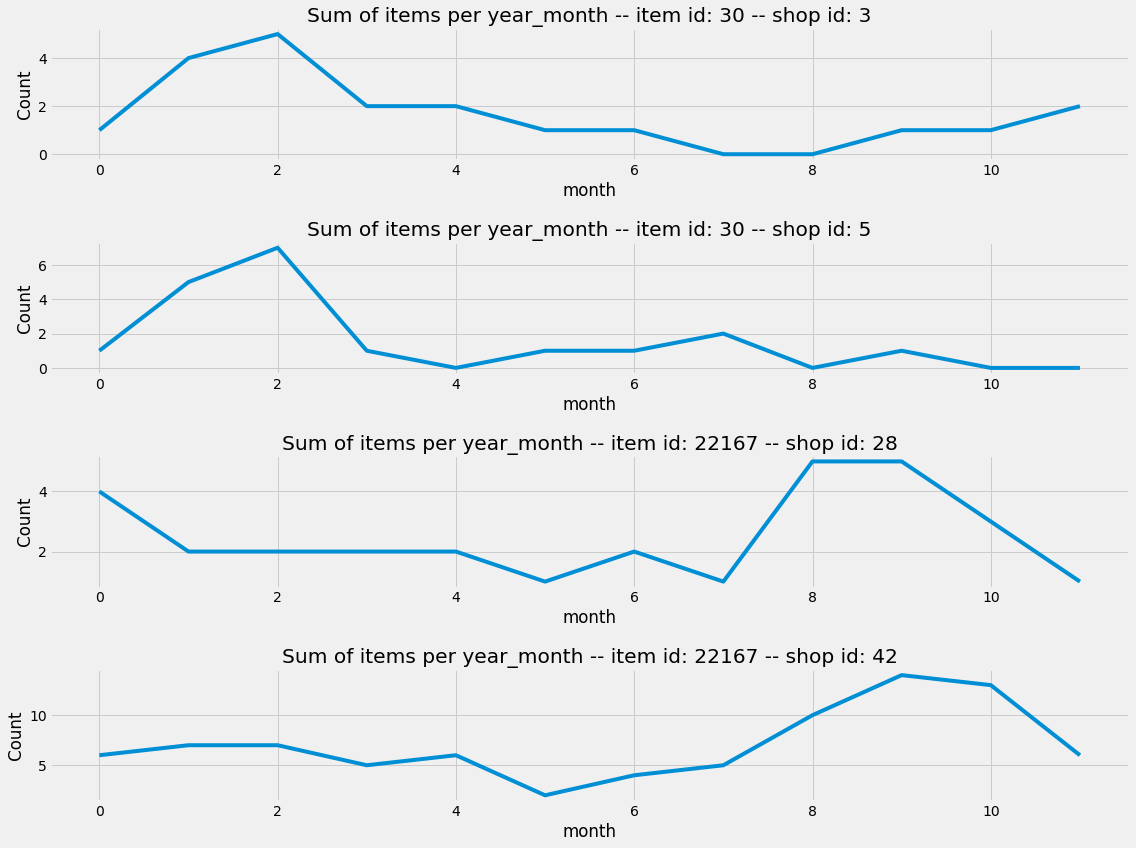

In [25]:
plt.style.use('fivethirtyeight')
plt.figure(figsize = (16, 12))

cnt_item_by_month = train_by_month.groupby(['month',"shop_id","item_id"],as_index=False)['item_cnt'].sum()
cnt_ctg_by_month = train_by_month.groupby(['month','item_category_id'], as_index=False)['item_cnt'].sum()

rand_item_id = [30,30,22167,22167] ## 'randomly' picking examples
rand_shop_id = [3,5,28,42]
num_plots = len(rand_item_id)
i=0
# iterate through the sources
for item, shop in zip(rand_item_id,rand_shop_id):
    # create a new subplot for each source
    plt.subplot(num_plots, 1, i + 1)
    temp = cnt_item_by_month[["shop_id","item_id","month","item_cnt"]]
    temp = cnt_item_by_month.loc[(cnt_item_by_month['item_id'] == item) & (cnt_item_by_month['shop_id'] == shop)]
    plt.plot(temp["month"],temp["item_cnt"]);

    plt.title('Sum of items per year_month -- item id: %s -- shop id: %s' %(item,shop)); plt.xlabel('month'); plt.ylabel('Count')
    i+=1
plt.tight_layout(h_pad = 1.5)

#cleaning out the memory
gc.enable
del rand_item_id,rand_shop_id,temp, num_plots, shop_ids,item_ids,empty_df
gc.collect

* Those plots are just examples got from the data, an overall view of the data is better
* Gonna plot all the items sales per month,I expect to see an increase in sales by the end of the year.

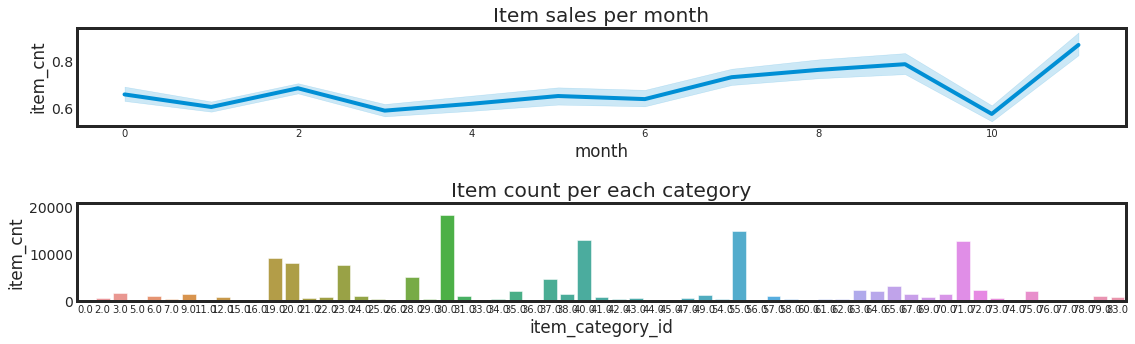

In [26]:
sns.set_style('ticks')
plt.figure(figsize = (16, 5))
plt.subplot(2,1,1)
sns.lineplot(x='month',y='item_cnt', data=cnt_item_by_month);plt.xticks(fontsize=10); plt.title('Item sales per month')
plt.subplot(2,1,2)
sns.barplot(x='item_category_id',y='item_cnt', data=cnt_ctg_by_month,errwidth=0);plt.xticks(fontsize=10); plt.title('Item count per each category')
plt.tight_layout(h_pad = 1.5)

* it can be seen, two categories have the largest item count, category 30 and 55

Text(0.5, 1.0, 'Item count per shopping id')

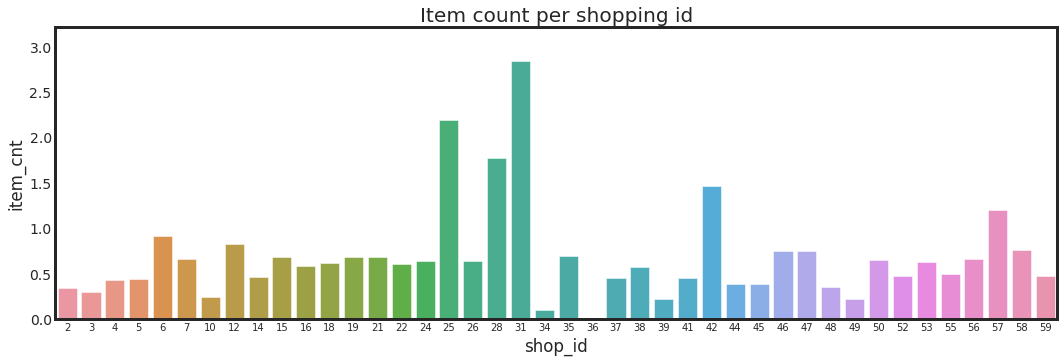

In [27]:
plt.figure(figsize = (16, 5))

sns.barplot(x='shop_id',y='item_cnt', data=cnt_item_by_month,errwidth=0);plt.xticks(fontsize=10); plt.title('Item count per shopping id')

* 3 stores seems to have a significant better performance.

* Gonna create a column which is gonna be our target, items count per month, sorting by the month and grouping by the ids. gonna use the shift -1 function to shift the time period to one month ahead in time
* before that, however, gonna check the item price and item count for outliers.

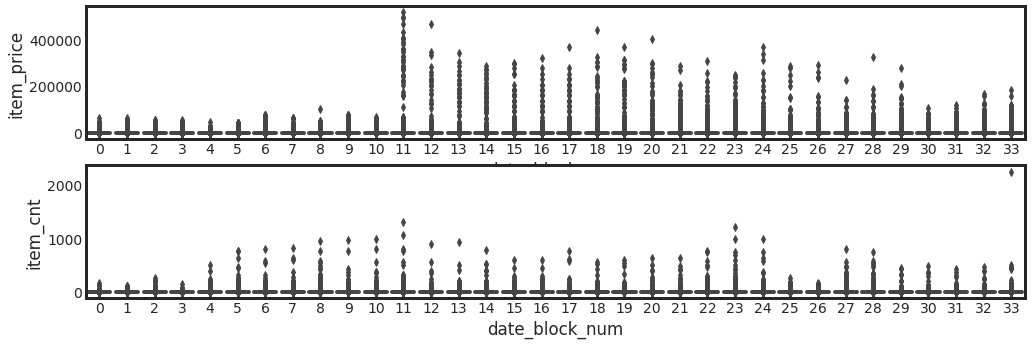

In [28]:
ax, fig = plt.subplots(1,1, figsize=(15,5))
plt.subplot(2,1,1)
sns.boxplot(x='date_block_num', y='item_price', data=train_by_month)
plt.subplot(2,1,2)
sns.boxplot(x='date_block_num', y='item_cnt', data=train_by_month)

** It seems that we have outliers for items prices and items count per day, isn't it? I wouldn't say that item count per day is exactly an outlier, it might be a normal value, 2000 items is not an abnormal number **

In [29]:
train_by_month[train_by_month['item_price'] > 500000].count() #checking for the item_price higher than 500000

date_block_num      1
shop_id             1
item_id             1
item_category_id    1
item_price          1
mean_item_price     1
item_cnt            1
mean_item_cnt       1
transactions        1
year                1
month               1
dtype: int64

In [30]:
train_by_month[train_by_month['item_cnt'] > 20].count() #checking for item count above 20

date_block_num      6087
shop_id             6087
item_id             6087
item_category_id    6087
item_price          6087
mean_item_price     6087
item_cnt            6087
mean_item_cnt       6087
transactions        6087
year                6087
month               6087
dtype: int64

it seems reasonable to keep only item_price < 500000 and clip the value for item count >=0 <=20

In [31]:
train_by_month = train_by_month.query('item_price < 500000 and item_cnt >= 0 and item_cnt <= 20')

* now, our target is gonna be item count per month, it's a forecasting problem, we must see one month ahead, so I am gonna use the shift method, -1, for the 34th month.

In [32]:
train_by_month['item_cnt_month'] = train_by_month.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)
train_by_month.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month
0,0,2,5572,2.0,10730.000000,1533.0,9.0,1.286133,7.0,2013,0,1.0
1,0,2,5643,2.0,2390.000000,2390.0,1.0,1.000000,1.0,2013,0,0.0
2,0,2,5583,5.0,1188.300049,594.0,2.0,1.000000,2.0,2013,0,1.0
3,0,2,7893,6.0,5970.000000,1990.0,3.0,1.000000,3.0,2013,0,2.0
4,0,2,7894,6.0,1490.000000,1490.0,1.0,1.000000,1.0,2013,0,2.0


In [33]:
train_by_month.tail()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month
6734443,33,36,9103,0.0,0.0,0.0,0.0,0.0,0.0,2015,9,NaN
6734444,33,36,9107,0.0,0.0,0.0,0.0,0.0,0.0,2015,9,NaN
6734445,33,36,5704,0.0,0.0,0.0,0.0,0.0,0.0,2015,9,NaN
6734446,33,36,12733,0.0,0.0,0.0,0.0,0.0,0.0,2015,9,NaN
6734447,33,36,15925,0.0,0.0,0.0,0.0,0.0,0.0,2015,9,NaN


In [34]:
print("The shape of the training data before feature engineering: {}".format(train_by_month.shape))

The shape of the training data before feature engineering: (6728361, 12)


### - Feature Engineering -

* Rolling 3 months back, getting the mean value across 3 months, the minimum value, the maximum and standard deviation.
* then, using shift, and 3 months as the lag period to create the count per month for each item for the previous 3 months.

In [35]:
# Min value
r_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
r_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
r_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
r_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [r_min, r_max, r_mean, r_std] #list with the each function above listed that is gonna be applied taking the last 3 months
function_name = ['min', 'max', 'mean', 'std'] #names of the functions

for i in range(len(function_list)):
    train_by_month[('item_cnt_%s' % function_name[i])] = train_by_month.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

# Fill the empty std features with 0
train_by_month['item_cnt_std'].fillna(0, inplace=True)

In [36]:
lag_list = [1, 2, 3] #creating a lag list with each month, 1, 2 and 3 months later.

for lag in lag_list: #going through the list of months
    ft_name = ('item_cnt_%s_month_before' % lag) # lag number of months before, getting the previous item count per month
    train_by_month[ft_name] = train_by_month.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_by_month[ft_name].fillna(0, inplace=True)

In [37]:
train_by_month['item_trend'] = train_by_month['item_cnt'] #firstly, the item trend is equal to the item count.

for lag in lag_list: #searching for each lag feature, then subtracting it from the trend value.
    ft_name = ('item_cnt_%s_month_before' % lag)
    train_by_month['item_trend'] -= train_by_month[ft_name]

train_by_month['item_trend'] /= len(lag_list) + 1 #finally, dividing it by 3 months + 1


** Features has been created, taking a look at the dataframe **

In [38]:
train_by_month.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_1_month_before,item_cnt_2_month_before,item_cnt_3_month_before,item_trend
0,0,2,5572,2.0,10730.000000,1533.0,9.0,1.286133,7.0,2013,0,1.0,9.0,9.0,9.0,0.0,0.0,0.0,0.0,2.25
1,0,2,5643,2.0,2390.000000,2390.0,1.0,1.000000,1.0,2013,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.25
2,0,2,5583,5.0,1188.300049,594.0,2.0,1.000000,2.0,2013,0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.50
3,0,2,7893,6.0,5970.000000,1990.0,3.0,1.000000,3.0,2013,0,2.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.75
4,0,2,7894,6.0,1490.000000,1490.0,1.0,1.000000,1.0,2013,0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.25


#### after having created the features, we are gonna split the dataset taking into consideration that our task here is to predict one month ahead in time for our testing set. Accordingly, as the first 3 months don't have lag futures(as it was created using past data, and we don't have data before the beggining of the dataset) we are gonna use for our training set the 3th month on, until the 27th, to train the model. For the validation set, the next subsequent months until the last one, the 28th month until the 32th month. Finally, for the testing set...the 33th month.

In [39]:
train_final = train_by_month.query('date_block_num >= 3 and date_block_num < 28').copy()
train_validation_final = train_by_month.query('date_block_num >= 28 and date_block_num < 33').copy()

train_final.dropna(inplace=True) #dropping any NaN values
train_validation_final.dropna(inplace=True) #dropping any NaN values
 
#dropping item category ID as we don't have it in our testing set.
train_final.drop(['item_category_id'], axis=1, inplace=True) 
train_validation_final.drop(['item_category_id'], axis=1, inplace=True)

print("Training set: {}".format(train_final.shape)+"\nValidation set: {}"
      .format(train_validation_final.shape))

Training set: (4946959, 19)
Validation set: (989473, 19)


* As we are gonna have different month, year, items and shop in each set, we are gonna do a mean enconding after having split the sets, this is gonna give us more features to work with. 

In [40]:
#grouping by shopping id, item count per month by shopping ID
gp_shop_mean = train_final.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
#grouping by item ID, item count per month by item ID
gp_item_mean = train_final.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
#grouping by shopping id and item ID, item count per month by shopping ID and item ID
gp_shop_item_mean = train_final.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
#grouping by year and getting the item cnt per month mean
gp_year_mean = train_final.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
#grouping by month and getting the item cnt per month mean
gp_month_mean = train_final.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

# Merging the features created into the train final dataset
train_final = pd.merge(train_final, gp_shop_mean, on=['shop_id'], how='left')
train_final = pd.merge(train_final, gp_item_mean, on=['item_id'], how='left')
train_final = pd.merge(train_final, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_final = pd.merge(train_final, gp_year_mean, on=['year'], how='left')
train_final = pd.merge(train_final, gp_month_mean, on=['month'], how='left')
# Merging the features created into the validation dataset
train_validation_final = pd.merge(train_validation_final, gp_shop_mean, on=['shop_id'], how='left')
train_validation_final = pd.merge(train_validation_final, gp_item_mean, on=['item_id'], how='left')
train_validation_final = pd.merge(train_validation_final, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_validation_final = pd.merge(train_validation_final, gp_year_mean, on=['year'], how='left')
train_validation_final = pd.merge(train_validation_final, gp_month_mean, on=['month'], how='left')

#finally, adding those features created to our testing set as well
additional_features = pd.concat([train_final, train_validation_final]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
test_final = pd.merge(test, additional_features, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
test_final['year'] = 2015 #setting the month and year manually, we are predicting the next month, setting the current month to 9 then
test_final['month'] = 9
test_final = test_final[train_final.columns]#selecting only the columns present in the training set, keeping it aligned

print("Training set: {}".format(train_final.shape)+"\nValidation set: {}"
      .format(train_validation_final.shape) + "\nTesting set: {}".format(test_final.shape))

Training set: (4946959, 24)
Validation set: (989473, 24)
Testing set: (214200, 24)


**Finally, we are gonna prepare the labels for our training and validation set**

In [41]:
#this pipeline is gonna be use for numerical atributes and standard scaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler, MinMaxScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        #('robust_scaler', RobustScaler()),
        ('minmax_scaler', MinMaxScaler(feature_range=(0, 1)))
    ])

In [42]:
train_labels = train_final['item_cnt_month'].astype(int)
train_final.drop(['date_block_num','item_cnt_month'], axis=1,inplace=True)
train_val_labels = train_validation_final['item_cnt_month'].astype(int)
train_validation_final.drop(['date_block_num','item_cnt_month'], axis=1,inplace=True)

#dropping the target in our testing set
test_final.drop(['date_block_num','item_cnt_month'], axis=1,inplace=True)

print("Training set: {}".format(train_final.shape)+"\nValidation set: {}"
      .format(train_validation_final.shape) + "\nTesting set: {}".format(test_final.shape))

Training set: (4946959, 22)
Validation set: (989473, 22)
Testing set: (214200, 22)


## Now, implementing a function that is gonna help us test our models
### this function is gonna use cross fold validation

In [43]:
from sklearn.metrics import mean_squared_error
import time #implementing in this function the time spent on training the model
from catboost import CatBoostRegressor
from catboost import Pool
import lightgbm as lgb
import xgboost as xgb
import gc

cols = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_1_month_before', 
                'item_cnt_2_month_before', 'item_cnt_3_month_before', 'shop_mean', 
                'shop_item_mean', 'item_trend', 'mean_item_cnt','transactions','year','month']

#Selecting only relevant features(I ran the model before and selected the top features only), 
#ignoring item id, shopping id and using the pipeline to scale the data

def train_model(X, X_val, y, y_val, params=None, model_type='lgb', plot_feature_importance=False):
  
    evals_result={}
    
    X_train = num_pipeline.fit_transform(X.loc[:,cols])
    x_val = num_pipeline.fit_transform(X_val.loc[:,cols])
    
    if model_type == 'lgb':
        start = time.time()
        
        model = lgb.LGBMRegressor(**params, n_estimators = 10000, nthread = 4, n_jobs = -1)
        
        model.fit(X_train, y, eval_set=[(X_train, y), (x_val, y_val)], eval_metric='rmse', early_stopping_rounds=200,
                    verbose=50)
            
        y_pred_valid = model.predict(x_val, num_iteration=model.best_iteration_)
        
        end = time.time()
        
        #y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
        
        print('RMSE validation data: {}'.format(np.sqrt(mean_squared_error(y_val,y_pred_valid))))
        
        
        if plot_feature_importance:
            # feature importance
            fig, ax = plt.subplots(figsize=(12,10))
            lgb.plot_importance(model, max_num_features=50, height=0.8,color='c', ax=ax)
            ax.grid(False)
            plt.title("LightGBM - Feature Importance", fontsize=15)
            
        print('Total time spent: {}'.format(end-start))
        return model
            
    if model_type == 'xgb':
        start = time.time()
        
        model = xgb.XGBRegressor(**params, nthread = 4, n_jobs = -1)

        model.fit(X_train, y, eval_metric="rmse", 
                      eval_set=[(X_train, y), (x_val, y_val)],verbose=20,
                      early_stopping_rounds=50)
        
        y_pred_valid = model.predict(x_val, ntree_limit=model.best_ntree_limit)
        
        end = time.time()

        print('RMSE validation data: {}'.format(np.sqrt(mean_squared_error(y_val,y_pred_valid))))
        
        print('Total time spent: {}'.format(end-start))
        return model
            
    if model_type == 'cat':
        start = time.time()
        model = CatBoostRegressor(eval_metric='RMSE', **params)
        model.fit(X_train, y, eval_set=(x_val, y_val), 
                  cat_features=[], use_best_model=True)

        y_pred_valid = model.predict(x_val)
        
        print('RMSE validation data: {}'.format(np.sqrt(mean_squared_error(y_val,y_pred_valid))))
        
        end = time.time()
        
        if plot_feature_importance:
            feature_score = pd.DataFrame(list(zip(X.loc[:,cols].dtypes.index, model.get_feature_importance(Pool(X.loc[:,cols], label=y, cat_features=[])))), columns=['Feature','Score'])
            feature_score = feature_score.sort_values(by='Score', kind='quicksort', na_position='last')
            feature_score.plot('Feature', 'Score', kind='barh', color='c', figsize=(16,10))
            plt.title("Catboost Feature Importance plot", fontsize = 14)
            plt.xlabel('')

        print('Total time spent: {}'.format(end-start))
        return model
        
    # Clean up memory
    gc.enable()
    del model, y_pred_valid, X_test,X_train,X_valid, y_pred, y_train, start, end,evals_result, x_val
    gc.collect()


0:	learn: 0.9364429	test: 0.9519967	best: 0.9519967 (0)	total: 1.19s	remaining: 19m 47s
50:	learn: 0.7071004	test: 0.8169483	best: 0.8169483 (50)	total: 33.3s	remaining: 10m 20s
100:	learn: 0.6788690	test: 0.8158695	best: 0.8135969 (69)	total: 1m 6s	remaining: 9m 54s
150:	learn: 0.6710551	test: 0.8220336	best: 0.8135969 (69)	total: 1m 40s	remaining: 9m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8135969473
bestIteration = 69

Shrink model to first 70 iterations.
RMSE validation data: 0.8135969472897149
Dataset is provided, but PredictionValuesChange feature importance don't use it, since non-empty LeafWeights in model.
Total time spent: 145.04295253753662


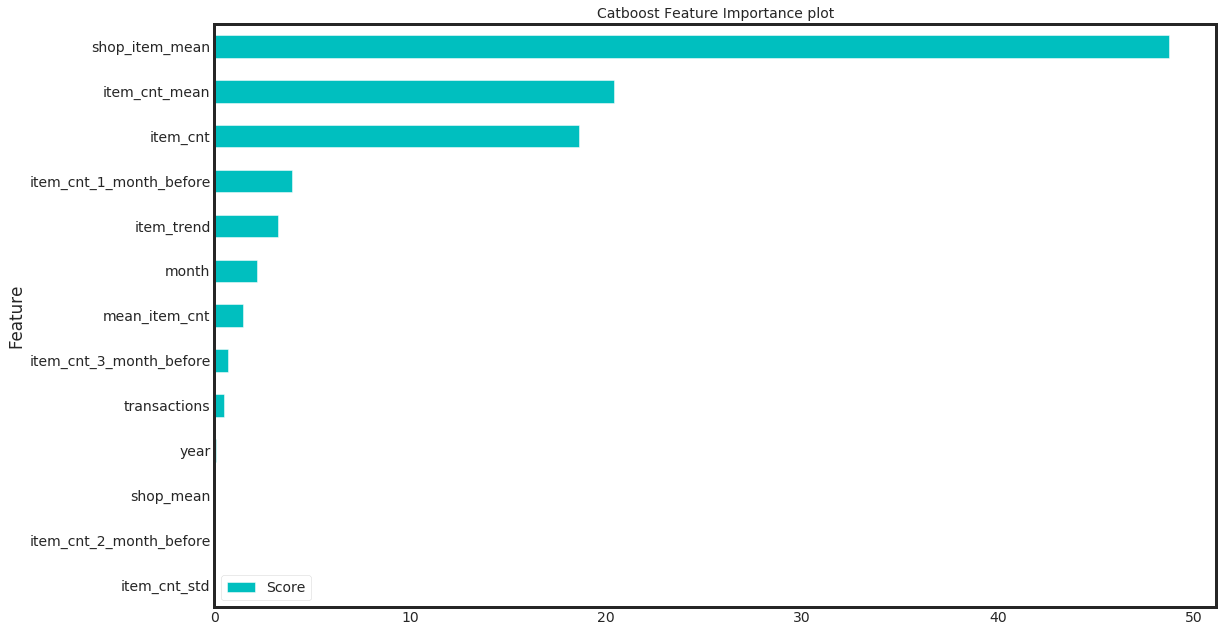

In [44]:
params_cat = {
    'iterations': 1000,
    'max_ctr_complexity': 4,
    'random_seed': 42,
    'od_type': 'Iter',
    'od_wait': 100,
    'verbose': 50,
    'depth': 4
}

cat_model = train_model(train_final,train_validation_final,train_labels,train_val_labels,params_cat,model_type='cat',plot_feature_importance=True)

In [45]:
params_lgb = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "min_child_weight" : 50,
        "learning_rate" : 0.009,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 42,
}

lgb_model = train_model(train_final,train_validation_final,train_labels,train_val_labels,params_lgb)

Training until validation scores don't improve for 200 rounds.
[50]	training's rmse: 0.798197	valid_1's rmse: 0.846243
[100]	training's rmse: 0.730965	valid_1's rmse: 0.812761
[150]	training's rmse: 0.696373	valid_1's rmse: 0.800592
[200]	training's rmse: 0.679329	valid_1's rmse: 0.795572
[250]	training's rmse: 0.668877	valid_1's rmse: 0.796338
[300]	training's rmse: 0.662787	valid_1's rmse: 0.798642
[350]	training's rmse: 0.659006	valid_1's rmse: 0.801667
[400]	training's rmse: 0.656171	valid_1's rmse: 0.80455
Early stopping, best iteration is:
[227]	training's rmse: 0.673163	valid_1's rmse: 0.795429
RMSE validation data: 0.7954289728799473
Total time spent: 86.23618578910828


In [46]:
params_xgb = {
    "max_depth": 8,
    "n_estimators": 5000,
    "learning_rate" : 0.05,
    "min_child_weight": 1000,  
    "colsample_bytree": 0.7, 
    "subsample": 0.7, 
    "eta": 0.3, 
    "seed": 42
}

xgb_model = train_model(train_final,train_validation_final,train_labels,train_val_labels,params_xgb,model_type="xgb")

[0]	validation_0-rmse:0.960248	validation_1-rmse:0.945571
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[20]	validation_0-rmse:0.725438	validation_1-rmse:0.806888
[40]	validation_0-rmse:0.673494	validation_1-rmse:0.798077
[60]	validation_0-rmse:0.66294	validation_1-rmse:0.806607
[80]	validation_0-rmse:0.658786	validation_1-rmse:0.815434
Stopping. Best iteration:
[40]	validation_0-rmse:0.673494	validation_1-rmse:0.798077

RMSE validation data: 0.7983171927588573
Total time spent: 470.1738998889923


In [47]:
#preparing the test dataset and passing it to each model...
test = num_pipeline.fit_transform(test_final.loc[:,cols])

prediction_cat = cat_model.predict(test)
prediction_lgb = lgb_model.predict(test)
prediction_xgb = xgb_model.predict(test)

sub = pd.read_csv('../input/sample_submission.csv')
final_prediction = (prediction_cat+prediction_lgb+prediction_xgb)/3
sub['item_cnt_month'] = final_prediction.clip(0., 20.)
sub.to_csv('mixed_sub.csv', index=False)
sub.head()

,ID,item_cnt_month
0,0,0.425604
1,1,0.038050
2,2,0.463712
3,3,0.037960
4,4,0.038050


#### Implementing a LSMT model on Keras TODO

In [48]:
cols = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_1_month_before',
        'item_cnt_2_month_before', 'item_cnt_3_month_before', 'shop_mean',
        'shop_item_mean', 'item_trend', 'mean_item_cnt','transactions','year','month']
X_train = num_pipeline.fit_transform(train_final.loc[:,cols])
X_val = num_pipeline.fit_transform(train_validation_final.loc[:,cols])
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)

#### importing relevant models ####
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Activation, ThresholdedReLU, MaxPooling2D, Embedding, Dropout
from keras.optimizers import Adam, SGD, RMSprop

# Defining the model layers
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss='mse', metrics=["mse"])
print(model_lstm.summary())


params_lstm = {"batch_size":64,
              "verbose":2,
              "epochs":10}

callbacks_list=[EarlyStopping(monitor="val_loss",min_delta=.001, patience=3,mode='auto')]
hist = model_lstm.fit(X_train, train_labels,
                      validation_data=(X_val, train_val_labels),
                      callbacks=callbacks_list,**params_lstm)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 13, 16)            1152      
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 7,457
Trainable params: 7,457
Non-trainable params: 0
___________________

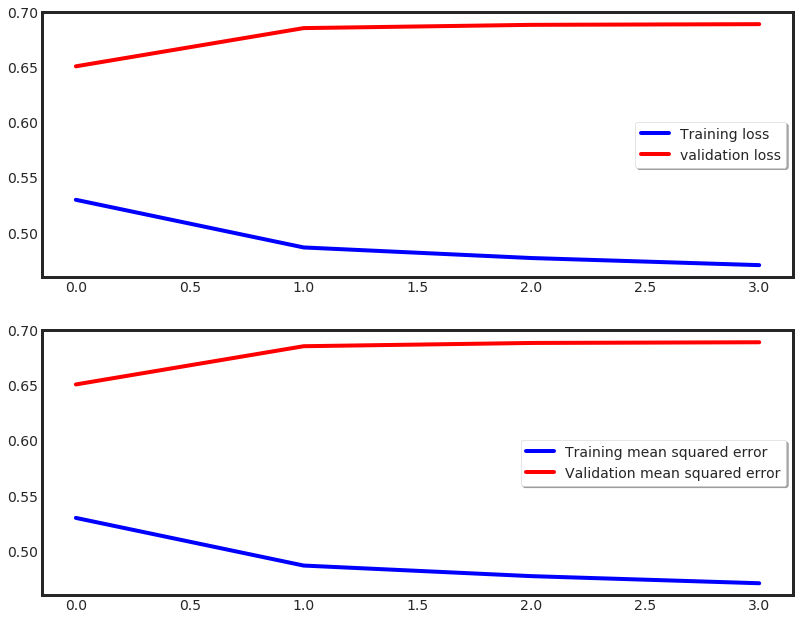

In [51]:
fig, ax = plt.subplots(2,1,figsize=(12,10))
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['mean_squared_error'], color='b', label="Training mean squared error")
ax[1].plot(hist.history['val_mean_squared_error'], color='r',label="Validation mean squared error")
legend = ax[1].legend(loc='best', shadow=True)

In [52]:
# predict results
X_test = np.expand_dims(test, axis=2)
results = model_lstm.predict(X_test)
sub['item_cnt_month'] = results.clip(0., 20.)
sub.to_csv('lstm.csv', index=False)
sub.head()

,ID,item_cnt_month
0,0,0.412973
1,1,0.008416
2,2,0.419117
3,3,0.008045
4,4,0.008416
